In [3]:
from Bio.PDB import *

import Bio.PDB as bpdb
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO
from Bio import SearchIO
from Bio.SeqUtils import seq1
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from Bio.PDB.Chain import Chain
from Bio.PDB.Atom import Atom
from Bio.PDB.Residue import Residue
from Bio.PDB.Model import Model

import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

import gudhi as gd
from scipy.optimize import minimize_scalar, least_squares

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d, gaussian_filter

import sys
import math

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

In [6]:
def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir

def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath


In [455]:
def get_files_with_ext(directory, ext):
    file_list = []
    for file in os.listdir(directory):
        if file.endswith(ext):
            file_list.append(file)
    return file_list

def get_geometries(directory):
    filenames = get_files_with_ext(directory, '.pdb')
    
    parser = PDBParser()
    geometries = {}
    for protein in filenames:
        name = os.path.splitext(protein)[0] # strip file extension
        chain = next(parser.get_structure('', os.path.join(directory, protein)).get_chains()) # 
        # chain = list(structure.get_chains())[0]
        geometries[name] = np.array([np.array(list(residue["CA"].get_vector())) for residue in chain.get_residues()])
        
    return geometries
        

In [8]:
def compromise(a, b):
    X = np.array([a,b])
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    Y = u @ vh
    return [*Y]

In [9]:
def visualize(*X):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for x in X:
        ax.plot(*x.T)

    plt.show()

In [168]:
def get_frame(dictionary, protid):
    preX = dictionary[protid]
    
    X = scipy.ndimage.gaussian_filter(preX, [1, 0]) # smoothed out curve
    dX = scipy.ndimage.gaussian_filter(X, [1, 0], order = 1) # tangent of backbone
    Y = scipy.ndimage.gaussian_filter(X, [20, 0]) # backbone
    dY = scipy.ndimage.gaussian_filter(Y, [1, 0], order = 1) # tangent of backbone
    dZ = dY / np.sqrt(np.sum(dY ** 2, axis = 1))[:, np.newaxis]
    
    V = np.zeros((len(dZ), 2, 3)) # V[i] is an orthonormal basis for the orthogonal complement of dZ[i]
    np.random.seed(100)
    V[0] = np.random.rand(2, 3)

    for i, z in enumerate(dZ):
        # project onto current tangent vector
        if i:
            V[i] = V[i-1]

        V[i] -= np.outer(V[i] @ z, z)
        V[i] = compromise(*V[i]) 

    Q = np.zeros((len(dZ), 4))
    for i in range(len(Q)):
        Q[i] = [(X[i] - Y[i]) @ V[i,0], (X[i] - Y[i]) @ V[i,1], (X[i] - Y[i]) @ dZ[i], dX[i] @ dZ[i]]

    return X, dX, Y, dY, dZ, V, Q

def get_winding(dictionary, protid):
    X, dX, Y, dY, dZ, V, Q = get_frame(dictionary, protid)
    
    s, c, q, dx = Q.T

    ds = gaussian_filter(s, 0.5, order = 1)
    dc = gaussian_filter(c, 0.5, order = 1)
    dq = gaussian_filter(q, 0.5, order = 1)

    r2 = s ** 2 + c ** 2

    summand = (c * ds - s * dc) / r2

    winding = np.cumsum(summand) / (2 * np.pi)
    
    # not in use currently:
    yaw = np.cumsum((c * dq - q * dc) / (q ** 2 + c ** 2)) / (2 * np.pi)
    roll = np.cumsum((s * dq - q * ds) / (s ** 2 + q ** 2)) / (2 * np.pi)
    
    return winding, s, c, q, dx


def projection(dictionary, protid):
    _, s, c, _, _ = get_winding(dictionary, protid)
    
    points = np.array([c, s]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    conf = range(len(s))
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
    norm = plt.Normalize(min(conf), max(conf))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(conf)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs, label = 'Residue number')

    plt.xlim(-21, 18)
    plt.ylim(-17, 12)
    # plt.savefig(make_path("plots", 'framing_projection_nlrome', f'{tairid}.png'), )
    # plt.close()
    plt.show()

    


In [11]:
# find the most common slope
# search among all segments with width in [small, big)
# give greater weight to longer segments and to those that fit better

def median_slope(data, small, big):
    slopes = []
    weights = []
    for i in range(len(data) - small):
        for j in range(i + small, min(i + big, len(data))):
            s = (data[j]-data[i])/(j-i)
            slopes.append(s)
            reg = data[i:j] - s * np.arange(i,j)
            reg -= np.mean(reg)
            # weights.append(np.sqrt(j - i))
            weights.append((j - i) / (1 + np.sum(reg ** 2)))
    
    n_bins = int(np.sqrt(len(slopes)))
    scores = [0 for i in range(n_bins)]
    a = min(slopes)
    b = max(slopes) + 0.01
    # print(a, b, n_bins)
    
    # bin_vals = np.arange(a, b, (b - a) / n_bins)
    # assert len(bin_vals) == len(scores)
    
    for s, weight in zip(slopes, weights):
        bin_index = int(n_bins * (s - a) / (b - a))
        try:
            scores[bin_index] += weight
        except:
            print(bin_index, n_bins, s, a, b)
        
    return a + (np.argmax(scores) / n_bins) * (b - a), scores




In [458]:
# we will try to fit a piecewise function that is constant, then linear of slope m,
# then constant. we will attempt to minimize
# an L2 penalty. 

# we proceed by gradient descent 
# we control three parameters: the left and right endpoints of the linear region,
# and an "intercept" parameter for the line

#any number of breakpoints

def get_segs(winding, params, slope):
    segs = []
    
    breakpts = [0]+list(params)+[len(winding)]
    for ii, (a, b) in enumerate(zip(breakpts[:-1], breakpts[1:])):
        a = int(a)
        b = int(b)
        seg = np.array(winding[a:b])
        if ii%2:
            try:
                seg -= slope*np.arange(a, b)
            except:
                print(a, b, params, slope)
                print(seg)
                print((slope*np.arange(a, b)))
                raise Exception()
        seg -= np.mean(seg)
        segs.append(seg)

    return segs

def loss_multi(winding, params, slope, penalties):
    segs = get_segs(winding, params,slope)
    return np.sum([penalties[ii%2]*np.sum(seg**2) for ii,seg in enumerate(segs)])

def plot_regression_multi(winding, params, slope, save = False, filename = ''):
    segs = get_segs(winding, params, slope)

    plt.plot(winding)
    breakpts = [0]+list(params)+[len(winding)]
    for ii, (a, b) in enumerate(zip(breakpts[:-1], breakpts[1:])):    
        a = int(a)
        b = int(b)
        
        g = winding[a:b]
        plt.plot(range(a, b), g - segs[ii])
    if save:
        plt.savefig(filename + '.png')
        plt.close()
    else:
        plt.show()

#two breakpoints

def get_premidpost(winding, params, slope):
    l, r = params
    l = int(l)
    r = int(r)
    
    pre = np.array(winding[:l])
    pre -= np.mean(pre)
    mid = winding[l:r] - (slope * (np.arange(l, r)))
    mid -= np.mean(mid)
    post = np.array(winding[r:])
    post -= np.mean(post)
    
    return pre, mid, post

def loss(winding, params, slope, penalties):
    pre, mid, post = get_premidpost(winding, params,slope)
    return penalties[0] * np.sum(pre ** 2) + penalties[1] * np.sum(mid ** 2) + penalties[0] * np.sum(post ** 2)

def plot_regression(winding, params, slope, save = False, filename = ''):
    l, r = params
    l = int(l)
    r = int(r)    
    pre, mid, post = get_premidpost(winding, params, slope)

    plt.plot(winding)
    plt.plot(np.arange(l), winding[:l] - pre, c= 'red')
    plt.plot(np.arange(l, r), winding[l:r] - mid, c = 'green')
    plt.plot(np.arange(r, len(winding)), winding[r:] - post, c = 'purple')
    plt.title('Piecewise linear regression on winding number graph')
    plt.axvline(l, linestyle = '--', c= 'r')
    plt.axvline(r, linestyle ='--', c = 'purple')
    plt.xlabel('Residue number')
    plt.ylabel('Winding number')
    
    if save:
        plt.savefig(filename + '.png')
        plt.close()
    else:
        plt.show()


## Running the pipeline

In [456]:
# run this once to load all structures into memory.
# A is a dictionary with with each key an IDs (filename with .pdb removed)
# and each value the numpy array defining the corresponding curve in R^3
A = get_geometries("nlrome_whole")

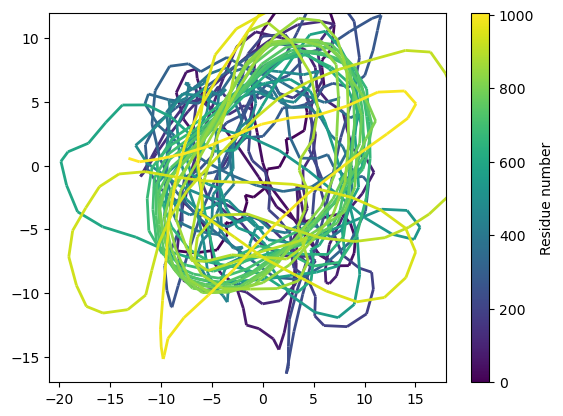

In [454]:
# protid = "AT4G09360.1"
# protid = "AT3G44670.1"
# protid = "AT1G17600.1"
# protid = "AT4G09360.1"
protid = 'AT3G44400.2'
# protid = "AT4G33300.2"

# visualization of total winding number as a function of residue
projection(A, protid)

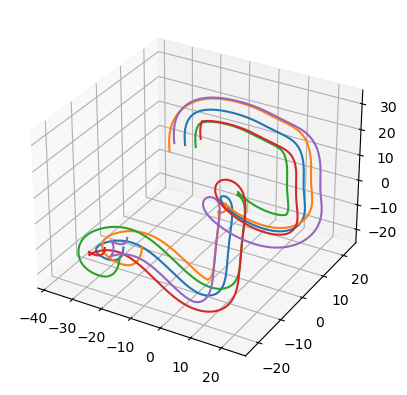

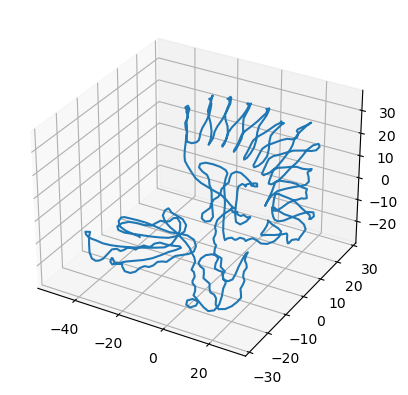

In [15]:
# testing out visualization of frames & the protein structure
X, dX, Y, dY, dZ, V, Q = get_frame(A, protid)
visualize(Y, Y + 5 * V[:,0,:][:], Y + 5 * V[:,1,:][:], Y - 5 * V[:,0,:], Y - 5 * V[:,1,:])
visualize(X)

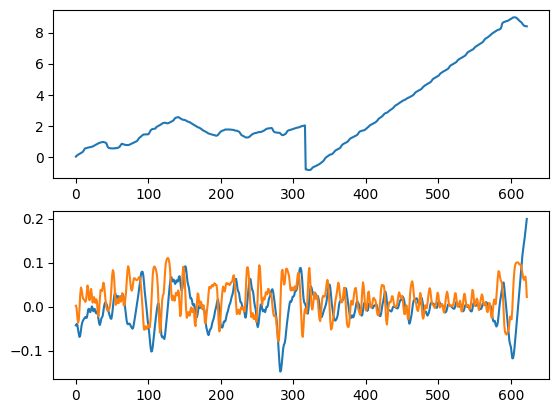

In [16]:
# in progress: attempting to use the "third coordinate" (i.e. height of curve
# above or below the normal plane) as a heuristic for where the LRR domain is

winding, s, c, q, dx = get_winding(A, protid)

fig = plt.figure()
ax = fig.add_subplot(211);
plt.plot(winding)

ax = fig.add_subplot(212);
kinetic = dx / np.linalg.norm(dx)
potential = q / np.linalg.norm(q)
# plt.plot(np.sqrt(np.cumsum(potential ** 2 + kinetic ** 2)))
plt.plot(potential)
plt.plot(kinetic)
plt.show()

In [188]:
# # saves regression for all proteins. only run if you haven't already computed params
# std_dev = {}
# slope_d = {}
# params_d = {}

# for protid in A:
#     # protid = 'AT1G72860.1'
#     winding, s, c, q, dx = get_winding(A, protid)

#     n = len(winding)
#     parameters = np.array([n // 2, (3 * n) // 4])
    
#     penalties = [1, 1.5]
#     epsilon = 0.01
#     gradient = np.zeros(2)
#     delta = [*np.identity(2)]
#     gradient_l = []
#     prev_grad = np.array(gradient)
#     thresh = .3

#     m, scores = median_slope(winding, 150, 250)
#     slope_d[protid] = m

#     for i in range(10000):
#         # inf, sup = int(parameters[0]), int(parameters[1])
#         # (m, b_opt), covariance = curve_fit(linear_func, range(inf, sup), winding[inf:sup])  
#         present = loss(winding, parameters, m, penalties)
#         if np.linalg.norm(gradient - prev_grad)< thresh and i > 0:
#             break
#         gradient_l.append(gradient)
#         gradient = np.array([loss(winding, parameters + d, m, penalties) - present for d in delta])
#         parameters = parameters - epsilon * gradient

#     # plot_regression(winding, parameters, m, save = False)
#     params_d[protid] = parameters
#     plot_regression(winding, parameters, m, save = True, filename = 'fig/piecewise_disc/' + protid)

# with open('pickles/std_dev.pickle', 'wb') as handle:
#     pickle.dump(std_dev, handle)
# with open('pickles/slope_d.pickle', 'wb') as handle:
#     pickle.dump(slope_d, handle)
# with open('pickles/params_d.pickle', 'wb') as handle:
#     pickle.dump(params_d, handle)       

In [373]:
parameters[1]>.95*len(winding)

True

In [415]:
# # plot all the regressions. assumes params has already been computed
# l_d = {}
# r_d = {}
# cutoff_d = {}
# for protid in A:
#     winding = wind_d[protid]
#     m = slope_d[protid]
#     parameters = list(params_d[protid])
#     if parameters[1]>.90*len(winding):
#         parameters[1] = len(winding)
#     if m<0:
#         winding = -winding
#         m = -m
#     cutoff_d[protid] = parameters
#     plot_regression(winding, parameters, m, save = True, filename = 'fig/piecewise_cutoff/' + protid)
#     # plt.plot(winding)
#     # plt.title('Cumulative winding number graph')
#     # plt.xlabel('Residue number')
#     # plt.ylabel('Winding number')
#     # plt.savefig(f'fig/windingnum/{protid}.png')
#     # plt.close()

# with open('pickles/cutoff_d.pickle', 'wb') as handle:
#     pickle.dump(cutoff_d, handle)       

/Users/boyanxu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/boyanxu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [412]:
#for generating chimera annotations
protid = 'AT3G44400.2'
l, r = cutoff_d[protid]
a, b = int(l), int(r)
N = len(wind_d[protid])
f = open("attr/cutoff-%s.txt"%protid, "w")
f.write("attribute: position\n")
f.write("recipient: residues\n")
for i in range(N):
    if i in (a, b):
        f.write("\t" + ":" + str(i+1) + "\t" + str(-1) + "\n")
    elif i < l:
        f.write("\t" + ":" + str(i+1) + "\t" + str(0) + "\n")
    elif i < r:
        f.write("\t" + ":" + str(i+1) + "\t" + str(1) + "\n")
    else:
        f.write("\t" + ":" + str(i+1) + "\t" + str(2) + "\n")
f.close()

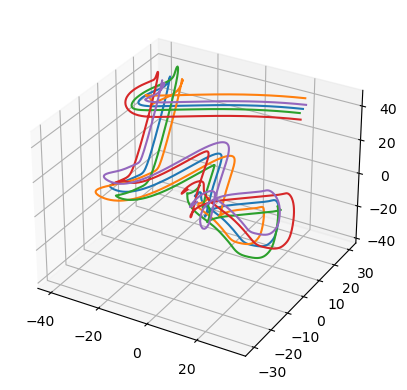

In [383]:
X, dX, Y, dY, dZ, V, Q = get_frame(A, protid)

visualize(Y, Y + 5 * V[:,0,:][:], Y + 5 * V[:,1,:][:], Y - 5 * V[:,0,:], Y - 5 * V[:,1,:])

In [397]:
print(Y[0,:].shape)
print(vf[ii,:].shape)

(3,)
(3,)


In [400]:
#generates core pdb file for figure in paper

for protid in A:
    if protid != 'AT3G44400.2':
        continue
    io = bpdb.PDBIO()
    parser = PDBParser()
    structure = parser.get_structure(protid, make_path('nlrome_whole', '%s.pdb'%protid))
    model = list(structure.get_models())[0]

    X, dX, Y, dY, dZ, V, Q = get_frame(A, protid)

    # visualize(Y, Y + 5 * V[:,0,:][:], Y + 5 * V[:,1,:][:], Y - 5 * V[:,0,:], Y - 5 * V[:,1,:])
    frame_iter = [np.zeros(Y.shape)]+[V[:,jj,:][:] for jj in range(2)]

    for jj, vf in enumerate(frame_iter):
        core_chain = Chain('C')
        for ii in range(Y.shape[0]):
            res = Residue((' ', ii, ' '), 'LEU', '')
            res.add(Atom('C', Y[ii, :]+5*vf[ii,:], 100, 1.0, ' ', 'C', ii,element='C'))
            core_chain.add(res)
        io.set_structure(core_chain)
        io.save(make_path('core', protid, '%d.pdb'%jj))
    break
    # v0_chain = Chain('U')
    # for ii in range(Y.shape[0]):
    #     res = Residue((' ', ii, ' '), 'LEU', '')
    #     res.add(Atom('C', Y[ii, :]+V0[ii, :], 100, 1.0, ' ', 'C', ii,element='C'))
    #     v0_chain.add(res)        
    # model.add(v0_chain)

    # v1_chain = Chain('V')
    # for ii in range(Y.shape[0]):
    #     res = Residue((' ', ii, ' '), 'LEU', '')
    #     res.add(Atom('C', Y[ii, :]+V1[ii, :], 100, 1.0, ' ', 'C', ii,element='C'))
    #     v1_chain.add(res)        
    # model.add(v1_chain)


    
    # io.save(make_path('pdb', 'nlrome_LRR-core','%s.pdb'%tairid))  


In [189]:
wind_d = {}
for protid in A:
    winding, s, c, q, dx = get_winding(A, protid)
    wind_d[protid] = winding

with open('pickles/wind_d.pickle', 'wb') as handle:
    pickle.dump(wind_d, handle)       

In [ ]:
protid = 'AT1G72860.1'
# AT3G14460.1

m = slope_d[protid]
winding = wind_d[protid]

n = len(winding)
l = n // 2
r = (3 * n) // 4
parameters = np.array([l,l+(l-r)/3,l+2*(l-r)/3, r ])
penalties = [1, 1.5]
epsilon = 0.01
gradient = np.zeros(len(parameters))
delta = [*np.identity(len(parameters))]
prev_grad = np.array(gradient)

thresh = .3

gradient_l = []
for i in range(10000):
    # inf, sup = int(parameters[0]), int(parameters[1])
    # (m, b_opt), covariance = curve_fit(linear_func, range(inf, sup), winding[inf:sup])  
    present = loss(winding, parameters, m, penalties)
    if np.linalg.norm(gradient - prev_grad)< thresh and i > 0:
        break
    gradient_l.append(gradient)
    gradient = np.array([loss(winding, parameters + d, m, penalties) - present for d in delta])
    parameters = parameters - epsilon * gradient

# plot_regression(winding, parameters, m, save = False)

In [108]:
# slope_d = {}
# for protid in A:
#     winding, s, c, q, dx = get_winding(A, protid)
#     m, scores = median_slope(winding, 150, 250)
#     slope_d[protid] = m
# with open('pickles/slope_d.pickle', 'wb') as handle:
#     pickle.dump(slope_d, handle)

In [291]:
std_dev = {}
for protid in A:
    # if protid != 'AT5G04720.1': continue
    winding = wind_d[protid]
    m = slope_d[protid]
    parameters = params_d[protid]
    l, r = parameters
    l = int(l)
    r = int(r)
    pre, mid, post = get_premidpost(winding, parameters, m)
    std_dev[protid] = np.std(mid)#, where =((bottom<mid) & (mid <top))|pad)
    plt.plot(mid)
    # plt.show()
    plt.savefig(f'fig/mid/{protid}.png')
    plt.close()

    # break

In [277]:
params = parameters
slope = m

segs = []

breakpts = [0]+list(params)+[len(winding)]
for ii, (a, b) in enumerate(zip(breakpts[:-1], breakpts[1:])):
    a = int(a)
    b = int(b)
    seg = winding[a:b] 
    if ii%2:
        try:
            seg -= slope*np.arange(a, b)
        except:
            print(a, b, params, slope)
            print(seg)
            print((slope*np.arange(a, b)))
            raise Exception()
    seg -= np.mean(seg)
    segs.append(seg)


5


(array([28., 26., 26., 18., 18., 16., 14.,  4.,  7.,  2.,  2.,  2.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
         2.,  1.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.05273579, 0.0971255 , 0.1415152 , 0.18590491, 0.23029461,
        0.27468432, 0.31907402, 0.36346372, 0.40785343, 0.45224313,
        0.49663284, 0.54102254, 0.58541225, 0.62980195, 0.67419165,
        0.71858136, 0.76297106, 0.80736077, 0.85175047, 0.89614018,
        0.94052988, 0.98491958, 1.02930929, 1.07369899, 1.1180887 ,
        1.1624784 , 1.20686811, 1.25125781, 1.29564751, 1.34003722,
        1.38442692, 1.42881663, 1.47320633, 1.51759603, 1.56198574,
        1.60637544, 1.65076515, 1.69515485, 1.73954456, 1.78393426,
        1.82832396, 1.87271367, 1.91710337, 1.96149308, 2.00588278,
        2.05027249, 2.09466219, 2.13905189, 2.1834416 , 2.2278313 ,
        2.27222101]),
 <BarContainer

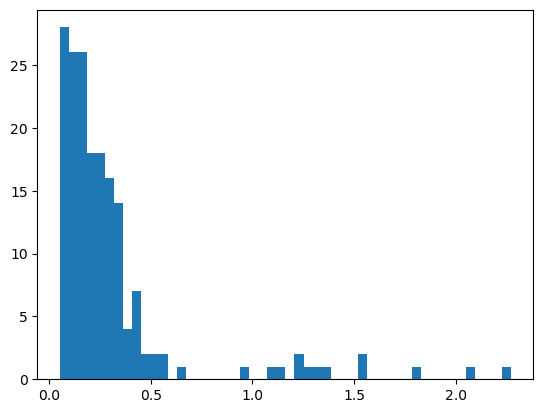

In [297]:
plt.hist(std_dev.values(), bins = 50)

In [298]:
badregs = [protid for protid in A if std_dev[protid]>.7]

In [341]:
protid = 'AT5G45050.1'
slope_d[protid]
tuple(list(params_d[protid]))

(559.9983521843634, 752.9986896212705)

In [342]:
start, end

(308, 948)

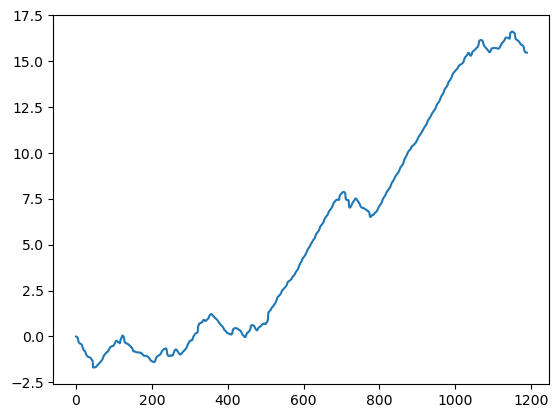

In [345]:
plt.plot(winding)

In [363]:
protid = 'AT5G17890.1'
winding = wind_d[protid]
parameters = params_d[protid]
l, r = parameters
l = int(l)
r = int(r)    
pre, mid, post = get_premidpost(winding, parameters, m)

start = np.where(np.diff(np.sign(pre)))[0][-1]
end = r+np.where(np.diff(np.sign(post)))[0][0]

m, scores = median_slope(winding[start:end], 20, 30)

In [361]:
slopes = []
small = start
big = end
data = winding
for i in range(len(data) - small):
    for j in range(i + small, min(i + big, len(data))):
        s = (data[j]-data[i])/(j-i)
        slopes.append(s)

(array([ 6746., 14704., 11597., 25412., 50670., 72913., 82082., 63675.,
        43807.,  4756.]),
 array([-0.00026906,  0.00274576,  0.00576058,  0.0087754 ,  0.01179022,
         0.01480504,  0.01781986,  0.02083467,  0.02384949,  0.02686431,
         0.02987913]),
 <BarContainer object of 10 artists>)

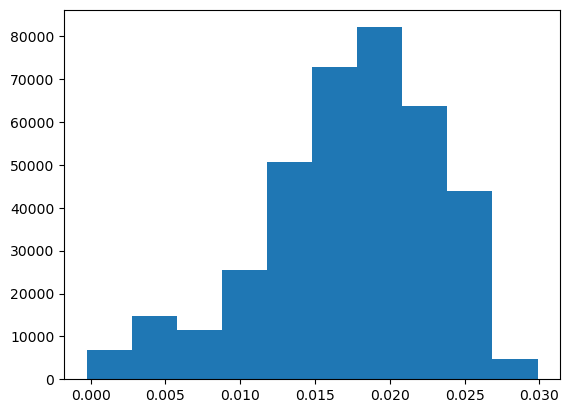

In [362]:
plt.hist(slopes)

(array([ 62.,   0.,   0.,   0.,   2.,   3.,   0.,   0.,   1., 109.]),
 array([-3.87142689e-02, -3.09827251e-02, -2.32511812e-02, -1.55196374e-02,
        -7.78809362e-03, -5.65498068e-05,  7.67499401e-03,  1.54065378e-02,
         2.31380816e-02,  3.08696254e-02,  3.86011693e-02]),
 <BarContainer object of 10 artists>)

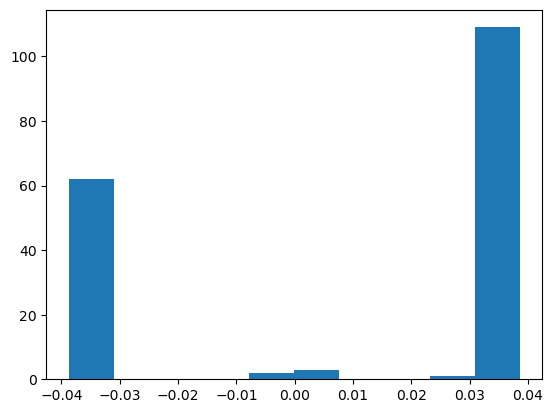

In [353]:
plt.hist(slope_d.values())

In [421]:
# regression with 4 breakpoints for all proteins
multi_parameters = {}

with open('pickles/params_d.pickle', 'rb') as handle:
    params_d = pickle.load(handle)


for protid in badregs:
    winding = wind_d[protid]
    parameters = params_d[protid]
    l, r = parameters
    l = int(l)
    r = int(r)    
    pre, mid, post = get_premidpost(winding, parameters, m)

    start = np.where(np.diff(np.sign(pre)))[0][-1]
    end = r+np.where(np.diff(np.sign(post)))[0][0]
    m, scores = median_slope(winding[start:end], 20, 30)

    n = len(winding)
    l = n // 2
    r = (3 * n) // 4
    parameters = np.array([l,l+(r-l)/3,l+2*(r-l)/3, r ])

    penalties = [1, 1.5]
    epsilon = 0.01
    gradient = np.zeros(4)
    delta = [*np.identity(4)]
    prev_grad = np.array(gradient)
    thresh = .3

    for i in range(10000):
        present = loss_multi(winding, parameters, m, penalties)
        if np.linalg.norm(gradient - prev_grad)< thresh and i > 0:
            break
        gradient = np.array([loss_multi(winding, parameters + d, m, penalties) - present for d in delta])
        parameters = parameters - epsilon * gradient
    multi_parameters[protid] = parameters
    if m < 0:
        m = -m
        winding = -winding
    
    plot_regression_multi(winding, parameters, m, filename = f'fig/piecewise_multi/{protid}', save = True)
with open('pickles/multi_parameters.pickle', 'wb') as handle:
    pickle.dump(multi_parameters, handle)   


In [433]:
#plot multi-breakpoints

# slopemulti_d = {}
for protid in badregs:
    winding = wind_d[protid]
    parameters = params_d[protid]
    l, r = parameters
    l = int(l)
    r = int(r)    
    pre, mid, post = get_premidpost(winding, parameters, m)

    start = np.where(np.diff(np.sign(pre)))[0][-1]
    end = r+np.where(np.diff(np.sign(post)))[0][0]
    m, scores = median_slope(winding[start:end], 20, 30)
    n = len(winding)

    if m < 0:
        m = -m
        winding = -winding

    slope = m
    params = multi_parameters[protid]

    segs = get_segs(winding, params, slope)

    plt.plot(winding)
    breakpts = [0]+list(params)+[len(winding)]
    for ii, (a, b) in enumerate(zip(breakpts[:-1], breakpts[1:])):    
        a = int(a)
        b = int(b)        
        g = winding[a:b]
        plt.plot(range(a, b), g - segs[ii])
        if np.abs(b-n)>4:
            plt.axvline(b, linestyle = '--', c= 'orange')        
    plt.title("Four breakpoint regression on winding number graph")
    plt.xlabel('Residue number')
    plt.ylabel('Winding number')

    plt.savefig(f'fig/piecewise_multi/{protid}.png')
    plt.close()        


In [429]:
multi_parameters[protid]

array([485.65379741, 681.20340433, 762.2508124 , 988.41557896])

In [452]:
#for generating chimera annotations
protid = 'AT1G72840.1'
params = [int(l) for l in multi_parameters[protid]]
N = len(wind_d[protid])
f = open("attr/multi-%s.txt"%protid, "w")
f.write("attribute: position\n")
f.write("recipient: residues\n")
for i in range(N):
    if i in params:
        f.write("\t" + ":" + str(i+1) + "\t" + str(-1) + "\n")
    else:
        segnum = int(np.sum([1 for breakpt in params if breakpt <i]))
        if segnum == 2:
            segnum = 0
        elif segnum%2:
            segnum = 1
        else:
            segnum = -3

        # if segnum == 2:
        #     segnum = -0.6
        f.write("\t" + ":" + str(i+1) + "\t" + str(segnum) + "\n")
f.close()


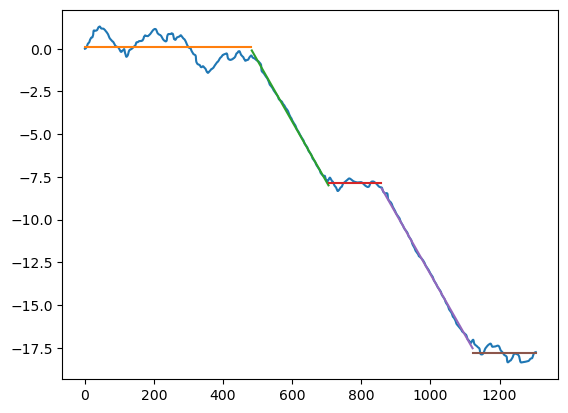

In [457]:

# regression with 4 breakpoints. multi
protid = 'AT1G72860.1'
winding, s, c, q, dx = get_winding(A, protid)

n = len(winding)
l = n // 2
r = (3 * n) // 4
parameters = np.array([l,l+(r-l)/3,l+2*(r-l)/3, r ])


penalties = [1, 1.5]
epsilon = 0.01
gradient = np.zeros(4)
delta = [*np.identity(4)]

prev_grad = np.array(gradient)
thresh = .3

m, scores = median_slope(winding, 150, 250)

for i in range(10000):
    present = loss_multi(winding, parameters, m, penalties)
    if np.linalg.norm(gradient - prev_grad)< thresh and i > 0:
        break
    gradient = np.array([loss_multi(winding, parameters + d, m, penalties) - present for d in delta])
    parameters = parameters - epsilon * gradient

plot_regression_multi(winding, parameters, m, save = False)

In [310]:
# for protid in [protid for protid in A if std_dev[protid]>.6]:
#     print(protid)
#     print(std_dev[protid])    
#     display(Image(filename=f'fig/piecewise_disc/{protid}.png'))


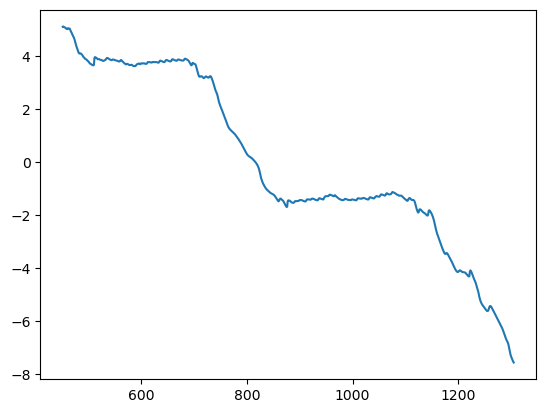

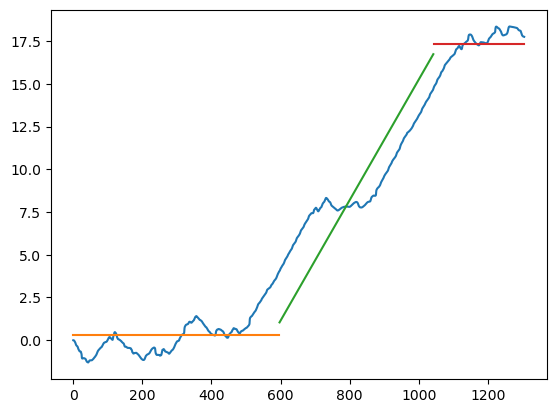

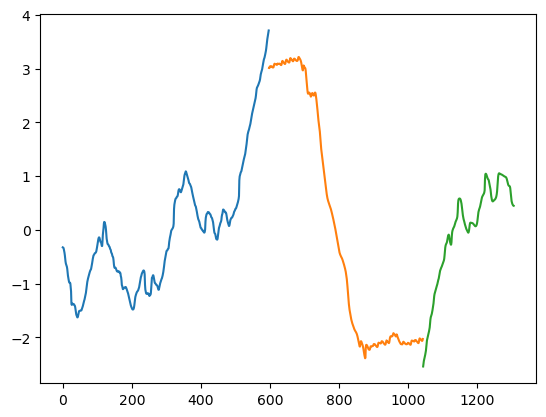

In [94]:
l, r = parameters
l = int(l)
r = int(r)    
pre, mid, post = get_premidpost(winding, parameters, m)

zero_crossings = np.where(np.diff(np.sign(pre)))[0]

start = [cross for cross in zero_crossings if cross < l][-1]
m, scores = median_slope(winding[start:], 150, 250)

residue = winding[start:] - m*np.arange(start,n)
residue -= np.mean(residue)

plt.plot(np.arange(start,n), residue)

plt.show()


# for ii in range(start, )


plt.plot(winding)
plt.plot(np.arange(l), winding[:l] - pre)
plt.plot(np.arange(l, r), winding[l:r] - mid)
plt.plot(np.arange(r, len(winding)), winding[r:] - post)
plt.show()
plt.plot(np.arange(l), pre)
plt.plot(np.arange(l, r), mid)
plt.plot(np.arange(r, len(winding)), post)

In [92]:
residue

array([ 5.16100238e+00,  5.17193647e+00,  5.15556528e+00,  5.14118813e+00,
        5.13443454e+00,  5.12018053e+00,  5.09985833e+00,  5.08057620e+00,
        5.07275008e+00,  5.09834234e+00,  5.10022685e+00,  5.08307775e+00,
        5.09202301e+00,  5.09064213e+00,  5.05455713e+00,  4.99941745e+00,
        4.96383169e+00,  4.92437287e+00,  4.87101327e+00,  4.82796498e+00,
        4.79367570e+00,  4.75218455e+00,  4.69872736e+00,  4.62939955e+00,
        4.54878428e+00,  4.47509236e+00,  4.40995640e+00,  4.35177483e+00,
        4.29363504e+00,  4.23443322e+00,  4.18277944e+00,  4.15096100e+00,
        4.14496424e+00,  4.15245366e+00,  4.14956723e+00,  4.13148723e+00,
        4.11003646e+00,  4.08667996e+00,  4.05392005e+00,  4.02048097e+00,
        4.00107409e+00,  3.98351347e+00,  3.95675898e+00,  3.93654273e+00,
        3.92811142e+00,  3.91633773e+00,  3.89090751e+00,  3.86909408e+00,
        3.85443810e+00,  3.83298923e+00,  3.80076150e+00,  3.77603175e+00,
        3.76203219e+00,  

In [ ]:
# AT1G72860.1
# AT1G72840.1
# AT1G72840.2
# AT1G72860.1

In [18]:
# Todo: incorporate graph Laplacian methods in pipeline
'''
for tairid in uniprot_d.keys():
    period = avgper(motifs_shifted_d[tairid])

    X = get_LRR_curve(tairid)
    X = X[:cutoff_d[tairid]]
    X = get_curv_vectors(X, MaxOrder=1, sigma=1)[1]
    # np.save(make_path('npy', 'nlrome_X', '%s.npy'%tairid), X)
            
    #print out the number of residues in the chain, and print the locations of the LRR motif residues

    D = get_csm(X, X)
    # Clean up the matrix a bit by doing a sliding window of length roughly the period
    D = sliding_window(D, period)
    # Clean up the matrix even more by binarizing it with nearest neighbors
    B = csm_to_binary_mutual(D, 50)
    #B = B[0:400, 0:400]
    v = getUnweightedLaplacianEigsDense(1-B)

    if True:
        plt.figure(figsize=(18, 6))
        plt.subplot(131)
        plt.imshow(D, cmap='magma_r')
        plt.title("Self-Similarity Matrix")
        plt.subplot(132)
        plt.imshow(B)
        plt.title("Binarized Self-Similarity Matrix")
        plt.subplot(133)
        plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
        for ii in motifs_shifted_d[tairid]:
            if ii in range(v.shape[0]):
                plt.axhline(ii)
        plt.title("Eigenvectors of Unweighted Graph Laplacian")
        plt.savefig(make_path('plots','eigenmatrix_nlrome_cutoff', '%s.png'%tairid))
        plt.close()

    np.save(make_path('npy', 'eigenmatrix_nlrome_cutoff', '%s.npy'%tairid), v)
''';